---
title: "Scraping Images from the Human Protein Atlas"
author: Favian Hatje
date: '08.07.2022'
format:
  html:
    code-fold: false
jupyter: python3
---

# Data Collection

We will be scraping histologic tissue slices from the [Human Protein Atlas](https://www.proteinatlas.org/), which they explicitly allow [here](https://www.proteinatlas.org/about/licence).

They provide datasets of available images and respective metadata. I am only interested in largeintestine, kidney, lung, spleen, prostate, preferably without stains.

Here is an (cropped) example:

![](podocin.png) 

In [1]:
import numpy as np
import pandas as pd
import shutil
from bs4 import BeautifulSoup as BS
import time
from tqdm import tqdm
import requests
from pathlib import Path
from PIL import Image

In [2]:
df = pd.read_csv("https://www.proteinatlas.org/download/normal_tissue.tsv.zip", delimiter="\t")
df.head()

,Gene,Gene name,Tissue,Cell type,Level,Reliability
0,ENSG00000000003,TSPAN6,adipose tissue,adipocytes,Not detected,Approved
1,ENSG00000000003,TSPAN6,adrenal gland,glandular cells,Not detected,Approved
2,ENSG00000000003,TSPAN6,appendix,glandular cells,Medium,Approved
3,ENSG00000000003,TSPAN6,appendix,lymphoid tissue,Not detected,Approved
4,ENSG00000000003,TSPAN6,bone marrow,hematopoietic cells,Not detected,Approved


Let's see which tissues they have images of.

In [3]:
df.Tissue.unique()

array(['adipose tissue', 'adrenal gland', 'appendix', 'bone marrow',
       'breast', 'bronchus', 'caudate', 'cerebellum', 'cerebral cortex',
       'cervix', 'colon', 'duodenum', 'endometrium 1', 'endometrium 2',
       'epididymis', 'esophagus', 'fallopian tube', 'gallbladder',
       'heart muscle', 'hippocampus', 'kidney', 'liver', 'lung',
       'lymph node', 'nasopharynx', 'oral mucosa', 'ovary', 'pancreas',
       'parathyroid gland', 'placenta', 'prostate', 'rectum',
       'salivary gland', 'seminal vesicle', 'skeletal muscle', 'skin 1',
       'skin 2', 'small intestine', 'smooth muscle', 'soft tissue 1',
       'soft tissue 2', 'spleen', 'stomach 1', 'stomach 2', 'testis',
       'thyroid gland', 'tonsil', 'urinary bladder', 'vagina', nan,
       'hypothalamus', 'endometrium', 'hair', 'retina',
       'lactating breast', 'skin', 'thymus', 'cartilage', 'eye',
       'pituitary gland', 'choroid plexus', 'dorsal raphe',
       'substantia nigra', 'sole of foot'], dtype=object)

Every tissue I am interest in is present! _(Colon = large Intestine)_ Let's get rid of everything else.

In [4]:
tissues = set("colon kidney lung prostate spleen".split())
mask = df.Tissue.isin(tissues)
df = df[mask]
df.Tissue.unique()

array(['colon', 'kidney', 'lung', 'prostate', 'spleen'], dtype=object)

_All_ images have been stained with some antibody, but we actually don't want stained images. That's why we're only keeping those images in which no antigen has been detected (meaning no visible stain is present in these images).

In [5]:
df = df[df.Level == "Not detected"]
df.Level.unique()

array(['Not detected'], dtype=object)

In [6]:
df.head()

,Gene,Gene name,Tissue,Cell type,Level,Reliability
20,ENSG00000000003,TSPAN6,colon,endothelial cells,Not detected,Approved
22,ENSG00000000003,TSPAN6,colon,peripheral nerve/ganglion,Not detected,Approved
35,ENSG00000000003,TSPAN6,kidney,cells in glomeruli,Not detected,Approved
40,ENSG00000000003,TSPAN6,lung,macrophages,Not detected,Approved
67,ENSG00000000003,TSPAN6,spleen,cells in red pulp,Not detected,Approved


Cell types and reliability are not relevant in this usecase, so let's just get rid of those columns. Also, the actual name of the gene is redundant.

In [7]:
del df["Cell type"], df["Reliability"], df["Level"], df["Gene name"]
df

,Gene,Tissue
20,ENSG00000000003,colon
22,ENSG00000000003,colon
35,ENSG00000000003,kidney
40,ENSG00000000003,lung
67,ENSG00000000003,spleen
...,...,...
1194410,ENSG00000288602,kidney
1194414,ENSG00000288602,lung
1194415,ENSG00000288602,lung
1194416,ENSG00000288602,lung


Some genes appear multiple times per organ. Let's remove those duplicates.

In [8]:
df = df.drop_duplicates(subset=["Gene", "Tissue"])
df

,Gene,Tissue
20,ENSG00000000003,colon
35,ENSG00000000003,kidney
40,ENSG00000000003,lung
67,ENSG00000000003,spleen
196,ENSG00000000457,lung
...,...,...
1194296,ENSG00000288558,lung
1194388,ENSG00000288602,colon
1194410,ENSG00000288602,kidney
1194414,ENSG00000288602,lung


Now, how many _genes per organ_ do we get?

In [9]:
df.groupby("Tissue").count()

,Gene
Tissue,
colon,7338
kidney,7732
lung,8747
prostate,5174
spleen,8924


To many to just download all at once, so we will randomly select 25 of each tissue. Since many genes have been more than one image, we will and up which 2-3 times as many images.

In [10]:
rand_indices = []
for t in df.Tissue.unique():
    rand_idx = list(np.random.choice(df[df.Tissue==t].index, size=25))
    rand_indices = [*rand_indices, *rand_idx]
df = df.loc[rand_indices]
df.groupby("Tissue").count()

,Gene
Tissue,
colon,25
kidney,25
lung,25
prostate,25
spleen,25


Now, we need to build the URL's of those images. Most genes have multiple images so we are going to expand our dataset with links to every image of every gene.

In [11]:
def build_url(embl, tissue): return f"https://www.proteinatlas.org/{embl}/tissue/{tissue}"
def extract_image_urls(htext):
    soup = BS(htext)
    image_urls = soup.body.findAll("img")
    image_urls = [il.get_attribute_list("src")[0] for il in image_urls]
    image_urls = [il for il in image_urls if "proteinatlas" in il]
    image_urls = ["https:"+im_url for im_url in image_urls]
    return image_urls

In [12]:
urls = []
for gene, tissue in tqdm(list(zip(df.Gene.values, df.Tissue.values))):
    url = build_url(gene, tissue)
    r = requests.get(url)
    if r.status_code != 200:
        print(f"Url: {url} didn't work")
        urls.append(None)
        continue
    urls.append(";".join(extract_image_urls(r.text)))
    time.sleep(0.1)
df["urls"] = urls

100%|██████████| 125/125 [01:39<00:00,  1.25it/s]


We save the data, so that we don't have to run this code twice.

In [13]:
df.to_csv("protein_atlas_scrape.csv", index=False)

And finally, we download the images.

In [14]:
def download_image(image_url, filename):
    try:
        r = requests.get(image_url, stream=True)
        if r.status_code == 200:
            r.raw.decode_content = True
            with open(filename,'wb') as f: shutil.copyfileobj(r.raw, f)
        else: return
    except: return

In [15]:
DOWNLOAD_DIR = Path("images")
DOWNLOAD_DIR.mkdir(exist_ok=True)
for _,row in tqdm(df.iterrows(), total=len(df)):
    for i, url in enumerate(row.urls.split(";")):
        image_name = DOWNLOAD_DIR/f"{row.Gene}_{row.Tissue}_{i}.jpg"
        download_image(url, image_name)
        time.sleep(0.1)

100%|██████████| 125/125 [03:17<00:00,  1.58s/it]


In [16]:
len(list(Path("images").iterdir()))

506

Now we have __506__ images! Let's look at a random one.

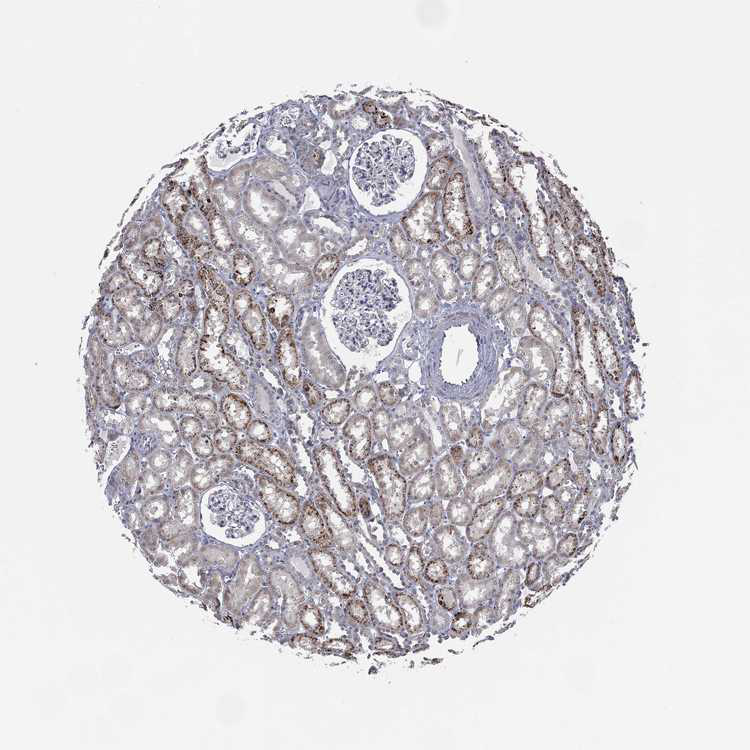

In [49]:
#| label: Scraped Image
#| fig-cap: Random Image from our new new dataset.
image_file = np.random.choice(list(Path("images").iterdir()))
Image.open(image_file)

And there we go! We now have histologic images we can use for anything we like.